<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/master/1_%E5%9F%BA%E7%9B%A4%E5%9C%B0%E5%9B%B3%E6%83%85%E5%A0%B1%E3%81%AE%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%81%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pysheds

ここでは基盤地図情報の数値標高モデル（DEM: Digital Elevation Model）を用いて分析する方法について解説していきます．

まず，[基盤地図情報のwebサイト](http://www.gsi.go.jp/kiban/)からDEMをダウンロードします．
ダウンロードしたデータは`FG-GML-5139-03-50-DEM5A-20161001.xml`とします．

このデータはXML型式になっていますので，
Pythonでxmlを扱うために`xml.etree.ElementTree`を`ET`として読み込みます．


In [0]:
import xml.etree.ElementTree as ET
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import math
#import glob
import pandas as pd
import io
import osgeo.gdal, osgeo.osr
# from osgeo import gdal, gdalconst, gdal_array, osr
#from pysheds.grid import Grid

from google.colab import drive

In [0]:
drive.mount('/content/drive')
base_dir = "/content/drive/My Drive/gisday2019/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


基盤地図情報のxmlを読み込んでparseします．
オブジェクト`tree`のルート要素を取得し，`elem`に代入します．

In [0]:
tree = ET.parse(base_dir + "GSI-DEM/FG-GML-5139-03-50-DEM5A-20161001.xml")
# tree = ET.parse(base_dir + "GSI-DEM/FG-GML-5139-03-68-DEM5A-20161001.xml")
# tree = ET.parse(base_dir + "GSI-DEM/FG-GML-5139-03-97-DEM5A-20161001.xml")
elem = tree.getroot()

`elem`を確認してみます．

In [0]:
elem

<Element '{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}Dataset' at 0x7f5c8f2e0bd8>

ルート要素のタグ`Dataset`が表示されました．

次にイテレータを使ってすべてのタグを取得し，それを表示してみます．


In [0]:
for e in elem.getiterator():
    print(e.tag)

{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}Dataset
{http://www.opengis.net/gml/3.2}description
{http://www.opengis.net/gml/3.2}name
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}DEM
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}fid
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}lfSpanFr
{http://www.opengis.net/gml/3.2}timePosition
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}devDate
{http://www.opengis.net/gml/3.2}timePosition
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}orgGILvl
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}orgMDId
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}type
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}mesh
{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}coverage
{http://www.opengis.net/gml/3.2}boundedBy
{http://www.opengis.net/gml/3.2}Envelope
{http://www.opengis.net/gml/3.2}lowerCorner
{http://www.opengis.net/gml/3.2}upperCorner
{http://www.opengis.net/gml/3.2}gridDomain
{http://www.opengis.net/gml/3.2}Grid
{http://www.opengis.net/gml/3.2}limits
{http://ww

基盤地図情報DEMのXMLは名前空間付きXMLです．
このため，タグへのアクセスには名前空間の接頭辞をつける必要があります．
たとえば，`find`メソッドを使ってタグ`mesh`にアクセスする場合，
通常のXMLのようにアクセスするとエラーが発生します．

In [0]:
mesh = elem.find(".//mesh")
print(mesh.text)

AttributeError: ignored


これを解決するためには，タグに紐づけられている名前空間のURIをタグごとに加える必要があります．
例えば以下のようにです．


In [0]:
mesh = elem.find(".//{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}mesh")
print(mesh.text)

51390350


しかし，すべてのタグにURIをつけるのは煩雑です．
プログラミングミスの原因にもなりかねません．
もう少しエレガントな方法としては，
タグのディクショナリをメソッドの第2引数に指定する方法があります．

以下はDEMのXMLの冒頭部です．
xmlnsで始まる部分が名前空間の定義になっており，それぞれURIが指定されています．


```xml
<?xml version="1.0" encoding="UTF-8"?>
<Dataset
  gml:id="Dataset1"
  xmlns="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema" 
  xmlns:xlink="http://www.w3.org/1999/xlink"
  xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
  xmlns:gml="http://www.opengis.net/gml/3.2"
  xsi:schemaLocation="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema FGD_GMLSchema.xsd"
>
```

これを元にして名前空間の接頭辞のディクショナリを作成します．
`xmlns="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema"`
はデフォルトの名前空間を指定しています．


In [0]:
ns = {'default': 'http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema',
  'xlink': 'http://www.w3.org/1999/xlink',
  'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'gml': 'http://www.opengis.net/gml/3.2'}

```xml
<?xml version="1.0" encoding="UTF-8"?>
<Dataset
  gml:id="Dataset1"
  xmlns="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema" 
  xmlns:xlink="http://www.w3.org/1999/xlink"
  xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
  xmlns:gml="http://www.opengis.net/gml/3.2"
  xsi:schemaLocation="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema FGD_GMLSchema.xsd"
>
  <gml:description>基盤地図情報メタデータ ID=fmdid:15-3101</gml:description>
  <gml:name>基盤地図情報ダウンロードデータ（GML版）</gml:name>
  <DEM gml:id="DEM001">
    <fid>fgoid:10-00100-15-60101-51390350</fid>
    <lfSpanFr gml:id="DEM001-1">
      <gml:timePosition>2016-10-01</gml:timePosition>
    </lfSpanFr>
    <devDate gml:id="DEM001-2">
      <gml:timePosition>2016-10-01</gml:timePosition>
    </devDate>
    <orgGILvl>0</orgGILvl>
    <orgMDId>H24GC009 NoData</orgMDId>
    <type>5mメッシュ（標高）</type>
    <mesh>51390350</mesh>
    <coverage gml:id="DEM001-3">
      <gml:boundedBy>
        <gml:Envelope srsName="fguuid:jgd2011.bl">
          <gml:lowerCorner>34.041666667 139.375</gml:lowerCorner>
          <gml:upperCorner>34.05 139.3875</gml:upperCorner>
        </gml:Envelope>
      </gml:boundedBy>
      <gml:gridDomain>
        <gml:Grid gml:id="DEM001-4" dimension="2">
          <gml:limits>
            <gml:GridEnvelope>
              <gml:low>0 0</gml:low>
              <gml:high>224 149</gml:high>
            </gml:GridEnvelope>
            </gml:limits>
            <gml:axisLabels>x y</gml:axisLabels>
        </gml:Grid>
      </gml:gridDomain>
      <gml:rangeSet>
        <gml:DataBlock>
          <gml:rangeParameters>
            <gml:QuantityList uom="DEM構成点"/>
          </gml:rangeParameters>
          <gml:tupleList>地表面,1.21 地表面,1.49. .......
        </gml:DataBlock>
      </gml:rangeSet>
      <gml:coverageFunction>
        <gml:GridFunction>
          <gml:sequenceRule order="+x-y">Linear</gml:sequenceRule>
          <gml:startPoint>155 12</gml:startPoint>
        </gml:GridFunction>
      </gml:coverageFunction>
    </coverage>
  </DEM>
</Dataset>
```

`elem`オブジェクトの`find`メソッドにURI付きのタグ`{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}mesh`を入力してタグを検索し，
その値を表示してみましょう．
戻り値（このタグの値）は標準地域メッシュ番号となっています．
最初の4桁`5139`が1次メッシュコード，
次の2桁が`03`が2次メッシュコード，
最後の2桁`50`が3次メッシュコードとなっています．

In [0]:
mesh = elem.find('.//default:mesh', ns)
print(mesh.text)

51390350


次に`{http://www.opengis.net/gml/3.2}lowerCorner`を表示してみます．
このタグにはDEMの南西端の座標が格納されています．

In [0]:
lowercorner = elem.find('.//gml:lowerCorner', ns)
print(lowercorner.text)

34.041666667 139.375


同様に`{http://www.opengis.net/gml/3.2}upperCorner`には
北東端の座標が格納されています．

In [0]:
uppercorner = elem.find('.//gml:upperCorner', ns)
print(uppercorner.text)

34.05 139.3875


タグ`{http://www.opengis.net/gml/3.2}tupleList`を検索し，値を表示する．
ここに標高が格納されている．
標高は文字列として格納されている．
改行コードとカンマで分けられている．
カンマの前が標高点の属性，カンマの後ろが標高値になっている．
データがないメッシュの属性は'データなし'で標高値は'-9999'，
データがあるメッシュの属性は'地表面'で標高値が実数で入っている．

In [0]:
tuplelist = elem.find(".//gml:tupleList", ns)
print(tuplelist.text)

標高値が格納されている文字列はcsvそのものになっており，
csvとして書き出せばpandasのpd.read_csv()でデータフレームに読み込むことができる．

しかし，いちいちcsvに書き出すのも面倒なため，io.StringIOを使ってテキストストリームを作成し，これにpandasのpd.read_csvを組み合わせてcsv型式の文字列をデータフレームに格納する．
列名も加える．

In [0]:
df = pd.read_csv(io.StringIO(tuplelist.text), header=None)
df.columns = ['att', 'z']
df

,att,z
0,地表面,1.21
1,地表面,1.49
2,地表面,1.18
3,データなし,-9999.00
4,データなし,-9999.00
...,...,...
21160,データなし,-9999.00
21161,データなし,-9999.00
21162,データなし,-9999.00
21163,データなし,-9999.00


データフレームの数は21165行$\times$2列になっている．
5mメッシュDEMの場合，格納されている標高値の列数と行数は`gml:high`と`gml:low`によって規定されている．両者を取得して確認してみる．

In [0]:
print(elem.find(".//gml:low", ns).text)
print(elem.find(".//gml:high", ns).text)

0 0
224 149


$(0, 0)$から$(224, 149)$の$225 \times 150$の合計33376メッシュになるはずだが，
実際には21165メッシュ分しか格納されていない．
これは，海面などで標高値がない部分が連続する場合，データを省略していることが原因である．
データの省略状況は，`gml:startPoint`に格納されている．

In [0]:
print(elem.find('.//gml:startPoint', ns).text)

155 12


これによると，標高値は155列12行から格納されていることがわかります．
しかし，これはデータの格納開始地点を表しているものであり，
終了地点を表すタグはありません．
足りない分は省略されていることになります．
実際，$(225-155)+((150-12) \times 225)$の30757メッシュが格納されているはずですが，
実際には21165メッシュしかないため，足りない分は省略されています．


dem | 0 | 1 | 2 | 3 |$\ldots$| 4|$\ldots$|244
-:|-:|-:|-:|-:|-:|-:|-:|-:|
**0**|0|10|20|30|$\ldots$|40|$\ldots$
**1**|0|10|20|30|$\ldots$|40|$\ldots$
$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|
**2**|0|10|20|30|$\ldots$|40|$\ldots$
**3**|0|10|20|30|$\ldots$|40|$\ldots$
**4**|0|10|20|30|$\ldots$|40|$\ldots$
$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|
**149**|0|10|20|30|40|

このため，このファイルに格納されている標高値は，
startPointよりも前の

154+(11*225)=2689メッシュ，

標高値がある分の21165メッシュ，
標高値の後の
33376-(2689+21165)メッシュ

になります．

dfに格納されている標高値に，メッシュの通し番号をつけていきます．
メッシュの初期値は155+(11*225)になります．
この値は`gml:startPoint`から取得します．
`gml:startPoint`の値はスペースで区切られています．
スペースの前が開始列番号，後ろが開始行番号です．
開始列番号を`startPointX`，開始行番号を`startPointY`とし，
`split`メソッドを使って分割します．
分割されて取得されるリストは文字列になっていますので，
`int`関数を使って整数値に変換します．



In [0]:
startPoint = elem.find('.//gml:startPoint', ns).text.split(' ')
startPointX = int(startPoint[0])
startPointY = int(startPoint[1])
print(startPointX, startPointY)

155 12


次に`range`関数を使って，標高値のあるメッシュの通し番号のリストを作成します．
開始番号は`startPointX+(225*startPointY)`で，
終了番号は開始番号に`df`の行数を足した値になります．
`df`の行数は`df.shape[0]`で取得できます．

In [0]:
cols = int(elem.find(".//gml:high", ns).text.split(' ')[0]) + 1
rows = int(elem.find(".//gml:high", ns).text.split(' ')[1]) + 1

start = startPointX + (cols * startPointY)
end = int(df.shape[0])
n = list(range(start, start + end))
len(n)

21165

dfに新しい列を加える

In [0]:
df['n'] = n
df

,att,z,n
0,地表面,1.21,2855
1,地表面,1.49,2856
2,地表面,1.18,2857
3,データなし,-9999.00,2858
4,データなし,-9999.00,2859
...,...,...,...
21160,データなし,-9999.00,24015
21161,データなし,-9999.00,24016
21162,データなし,-9999.00,24017
21163,データなし,-9999.00,24018


nの値からxとyを求める．
%は剰余，//は整数の商を求める演算子

In [0]:
df['x'] = (df['n'] % cols)
df['y'] = (df['n'] // cols)
df

,att,z,n,x,y
0,地表面,1.21,2855,155,12
1,地表面,1.49,2856,156,12
2,地表面,1.18,2857,157,12
3,データなし,-9999.00,2858,158,12
4,データなし,-9999.00,2859,159,12
...,...,...,...,...,...
21160,データなし,-9999.00,24015,165,106
21161,データなし,-9999.00,24016,166,106
21162,データなし,-9999.00,24017,167,106
21163,データなし,-9999.00,24018,168,106


座標埋め込みの原点（北西端の緯度経度）を取得する．
北西端の座標は`gml:upperCorner`と`gml:lowerCorner`から取得できる．
`gml:upperCorner`と`gml:lowerCorner`はそれぞれ北東端と南西端の座標を示しており，
スペースで区切られている．
`split()`使って緯度と経度を分割してリスト化し，左上X（`ULX`，Upper Left X），左上Y（`ULY`），右下X（`LRX`，Lower Right X），右下Y（`LRY`）を`float()`で実数にキャストして格納する．


In [0]:
uppercorner = elem.find('.//gml:upperCorner', ns)
lowercorner = elem.find('.//gml:lowerCorner', ns)

ULX = float(lowercorner.text.split(' ')[1])
ULY = float(uppercorner.text.split(' ')[0])
LRX = float(uppercorner.text.split(' ')[1])
LRY = float(lowercorner.text.split(' ')[0])
print(ULX, ULY, LRX, LRY)

139.375 34.05 139.3875 34.041666667


次に標高値ひとつあたりのX方向の長さ（単位は十進経度）とY方向の長さ（単位は十進緯度）を求める．
X方向の長さは右側経度`LRX`と左側経度`ULX`の差を東西メッシュ数`cols`で割ったものになる．
同様にY方向の長さは上側緯度`ULY`と下側緯度`LRY`の差を南北メッシュ数`rows`で割ったものになる．それぞれ`Xsize`と`Ysize`とする．





In [0]:
Xsize = (LRX - ULX) / cols
Ysize = (ULY - LRY) / rows
print(Xsize, Ysize)

5.555555555550503e-05 5.5555553333306305e-05


xとyを緯度軽度（十進緯度経度）に変換する．
標高値の並び順は`gml:sequenceRule`の属性`order`に’書かれている．
この場合は`+x-y`になっており，
これは開始地点からxがプラス方向（経度がプラス方向，すなわち東方向）にデータが並び，
一行分終わったらyがマイナス方向（緯度がマイナス方向，すなわち北半球では南方向）に一行分動くということを表している．






In [0]:
od = elem.find('.//gml:sequenceRule', ns)
od.attrib['order']

'+x-y'

In [0]:
df['lon'] = ULX + df['x'] * Xsize
df['lat'] = ULY - df['y'] * Ysize
df

,att,z,n,x,y,lon,lat
0,地表面,1.21,2855,155,12,139.383611,34.049333
1,地表面,1.49,2856,156,12,139.383667,34.049333
2,地表面,1.18,2857,157,12,139.383722,34.049333
3,データなし,-9999.00,2858,158,12,139.383778,34.049333
4,データなし,-9999.00,2859,159,12,139.383833,34.049333
...,...,...,...,...,...,...,...
21160,データなし,-9999.00,24015,165,106,139.384167,34.044111
21161,データなし,-9999.00,24016,166,106,139.384222,34.044111
21162,データなし,-9999.00,24017,167,106,139.384278,34.044111
21163,データなし,-9999.00,24018,168,106,139.384333,34.044111


`lat`と`lon`で`z`をピボットする．
値がない場所は`-9999`とする．

In [0]:
dem = df.pivot_table(index = 'lat', columns = 'lon', values = 'z', fill_value = -9999)
dem = dem.sort_index(ascending = False)
dem

lon,139.375000,139.375056,139.375111,139.375167,139.375222,139.375278,139.375333,139.375389,139.375444,139.375500,139.375556,139.375611,139.375667,139.375722,139.375778,139.375833,139.375889,139.375944,139.376000,139.376056,139.376111,139.376167,139.376222,139.376278,139.376333,139.376389,139.376444,139.376500,139.376556,139.376611,139.376667,139.376722,139.376778,139.376833,139.376889,139.376944,139.377000,139.377056,139.377111,139.377167,...,139.385278,139.385333,139.385389,139.385444,139.385500,139.385556,139.385611,139.385667,139.385722,139.385778,139.385833,139.385889,139.385944,139.386000,139.386056,139.386111,139.386167,139.386222,139.386278,139.386333,139.386389,139.386444,139.386500,139.386556,139.386611,139.386667,139.386722,139.386778,139.386833,139.386889,139.386944,139.387000,139.387056,139.387111,139.387167,139.387222,139.387278,139.387333,139.387389,139.387444
lat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34.049333,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
34.049278,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
34.049222,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
34.049167,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
34.049111,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34.044333,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999

ピボットした標高行列をnumpyのnp.ndarrayに変換する．

In [0]:
demp=dem.values.astype(np.float32)
demp

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

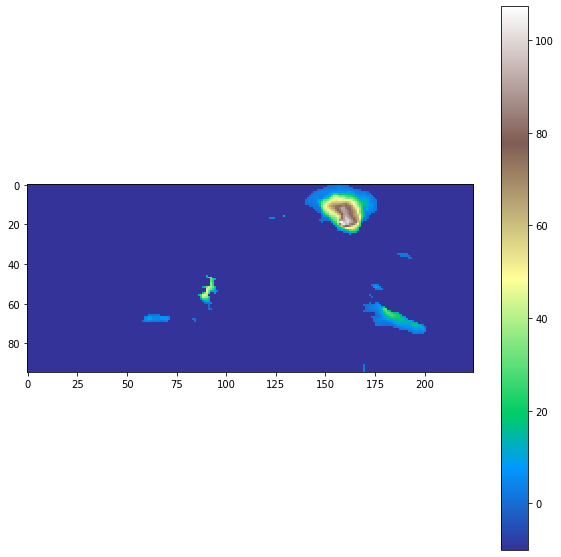

In [0]:
plt.figure(figsize = (10, 10))
im = plt.imshow(demp, cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()
#plt.savefig('slope_c.png')

GeoTiffで書き出し


In [0]:
trans = [min(df['lon']), Xsize, 0, max(df['lat']), 0, -Ysize]

srs = osgeo.osr.SpatialReference()
srs.ImportFromEPSG(4612)
driver = osgeo.gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'test.tif', demp.shape[1], demp.shape[0], 1, osgeo.gdal.GDT_Float32)
output.GetRasterBand(1).WriteArray(demp)
#output.GetRasterBand(1).WriteArray(demp)

output.GetRasterBand(1).SetNoDataValue(-9999)
output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())
output.FlushCache()
output = None

In [0]:

demp.shape

(95, 225)

全部入りのプログラム

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


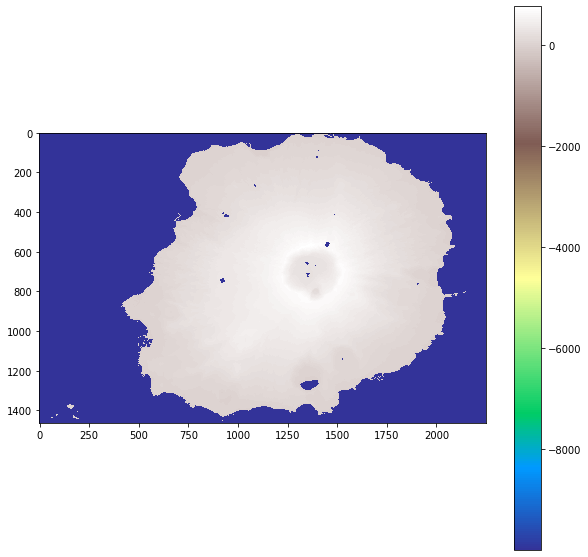

In [29]:
import xml.etree.ElementTree as ET
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import math
import glob
import pandas as pd
import io
from osgeo import gdal, gdalconst, gdal_array, osr
#from pysheds.grid import Grid

from google.colab import drive

drive.mount('/content/drive')
base_dir = "/content/drive/My Drive/gisday2019/"

ns = {'default': 'http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema',
  'xlink': 'http://www.w3.org/1999/xlink',
  'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'gml': 'http://www.opengis.net/gml/3.2'}

infiles = glob.glob(base_dir + '/GSI-DEM/*.xml')
dfall = pd.DataFrame()

# ここからループする

for infile in infiles:
  tree = ET.parse(infile)
  elem = tree.getroot()

  lowercorner = elem.find('.//gml:lowerCorner', ns)
  uppercorner = elem.find('.//gml:upperCorner', ns)

  tuplelist = elem.find(".//gml:tupleList", ns)
  df = pd.read_csv(io.StringIO(tuplelist.text), header = None)
  df.columns = ['att', 'z']

  startPoint = elem.find('.//gml:startPoint', ns).text.split(' ')
  startPointX = int(startPoint[0])
  startPointY = int(startPoint[1])

  cols = int(elem.find(".//gml:high", ns).text.split(' ')[0]) + 1
  rows = int(elem.find(".//gml:high", ns).text.split(' ')[1]) + 1

  start = startPointX + (cols * startPointY)
  end = int(df.shape[0])

  df['n'] = list(range(start, start + end))
  df['x'] = (df['n'] % cols)
  df['y'] = (df['n'] // cols)

  uppercorner = elem.find('.//gml:upperCorner', ns)
  lowercorner = elem.find('.//gml:lowerCorner', ns)

  ULX = float(lowercorner.text.split(' ')[1])
  ULY = float(uppercorner.text.split(' ')[0])
  LRX = float(uppercorner.text.split(' ')[1])
  LRY = float(lowercorner.text.split(' ')[0])

  Xsize = (LRX - ULX) / cols
  Ysize = (ULY - LRY) / rows

  df['lon'] = ULX + df['x'] * Xsize
  df['lat'] = ULY - df['y'] * Ysize

  dfall = dfall.append(df)


#データがない部分用のダミーデータを作る
d1 = pd.DataFrame()
d2 = pd.DataFrame()
d1['lon'] = list(np.arange(min(dfall['lon']), max(dfall['lon']), Xsize))
d1['lat'] = min(dfall['lat'])
d1['z'] = -9999

d2['lon'] = min(dfall['lon'])
d2['lat'] = list(np.arange(min(dfall['lat']), max(dfall['lat']), Ysize))
d2['z'] = -9999

df.append(d1).append(d2)

dem = dfall.pivot_table(index = 'lat', columns = 'lon', values = 'z', fill_value = -9999)
dem = dem.sort_index(ascending = False)


demp = dem.values.astype(np.float32)

plt.figure(figsize = (10, 10))
# im = plt.imshow(demp, cmap = "terrain",vmin = -10)
im = plt.imshow(demp, cmap = "terrain")

plt.colorbar(im)
plt.show()


trans = [min(dfall['lon']), Xsize, 0, max(dfall['lat']), 0, -Ysize]

srs = osgeo.osr.SpatialReference()
srs.ImportFromEPSG(4612)
driver = osgeo.gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'test.tif', demp.shape[1], demp.shape[0], 1, osgeo.gdal.GDT_Float32)
output.GetRasterBand(1).WriteArray(demp)
output.GetRasterBand(1).SetNoDataValue(-9999)

output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())
output.FlushCache()
output = None






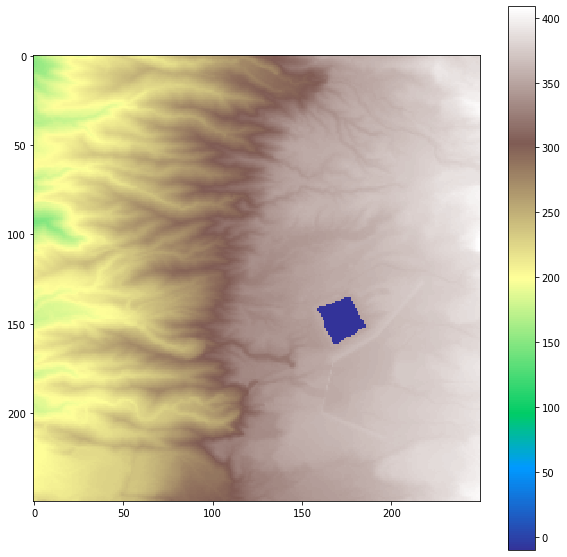

In [0]:
plt.figure(figsize = (10, 10))
im = plt.imshow(demp[600:850, 750:1000], cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

In [0]:
infiles

['/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-50-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-59-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-68-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-69-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-78-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-79-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-87-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-88-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-89-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-97-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-98-DEM5A-20161001.xml',
 '/content/drive/My Drive/gisday2019//GSI-DEM/FG-GML-5139-03-99-D

処理対象のファイル名を取得する．
処理対象は*.txtとする

In [0]:
infiles = glob.glob("*.txt")

In [0]:
for infile in infiles:

#データフレーム`dem`に標高データを読み込む．

#その後，列名に`X`，`Y`，`Z`をつける.

    dem = pd.read_csv(infile, delim_whitespace=True, header=-1)
    dem.columns = ['X', 'Y', 'Z']
    

#NoData（1.701410e+38）の値を-32768に置き換える．

    dem['Z2'] = dem['Z'].where(dem['Z'] != 1.701410e+38, -32768)

#縦持ちの標高データを横持ちに変換する．
#その後，Y方向でソートして南北の順を整列させる．

    asc_ras = dem.pivot_table(index = 'Y', columns = 'X', values = 'Z2', fill_value = 0)
    asc_ras = asc_ras.sort_index(ascending = False)

#ASCIIラスターのヘッダをつける．
#ヘッダの型式は以下になっている.

#```
#ncols 2000
#nrows 1500
#xllccenter 378923
#yllcenter 4072345
#cellsize 1
#nodata_value -32768
#43 2 45 7 3 56 2 5 23 65 34 6 32 54 57 34 2 2 54 6 
#35 45 65 34 2 6 78 4 2 6 89 3 2 7 45 23 5 8 4 1 62 ...
#```

#ヘッダは横持ちにしたDEMから取得する.

    headers = "ncols %d\n" % len(asc_ras.columns) \
        + "nrows %d\n" % len(asc_ras.index) \
        + "xllcenter %f\n" % dem['X'].min() \
        + "yllcenter %f\n" % dem['Y'].min() \
        + "cellsize 1\n" \
        + "nodata_value -32768\n"

#ヘッダを書き出す

    f = open(infile+'.asc', 'w')
    f.write(headers)

#横持ちにしたDEM本体をアペンドモードで書き出す．

    with open(infile+'.asc', 'a') as f:
        asc_ras.to_csv(f, index = False, header = False, sep =' ')